Importing Required Libraries

In [61]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
#from tf.keras.optimizers.legacy.Adam import lr
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

Path for Dataset

In [62]:
data_dir = 'gtsrb-german-traffic-sign'
train_path = 'gtsrb-german-traffic-sign/Train'
test_path = 'gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

Finding Total Classes

In [63]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [64]:
# Label Overview  (Gắn nhãn)
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right',
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Visualizing The Dataset (Trực quan hoá dataset)


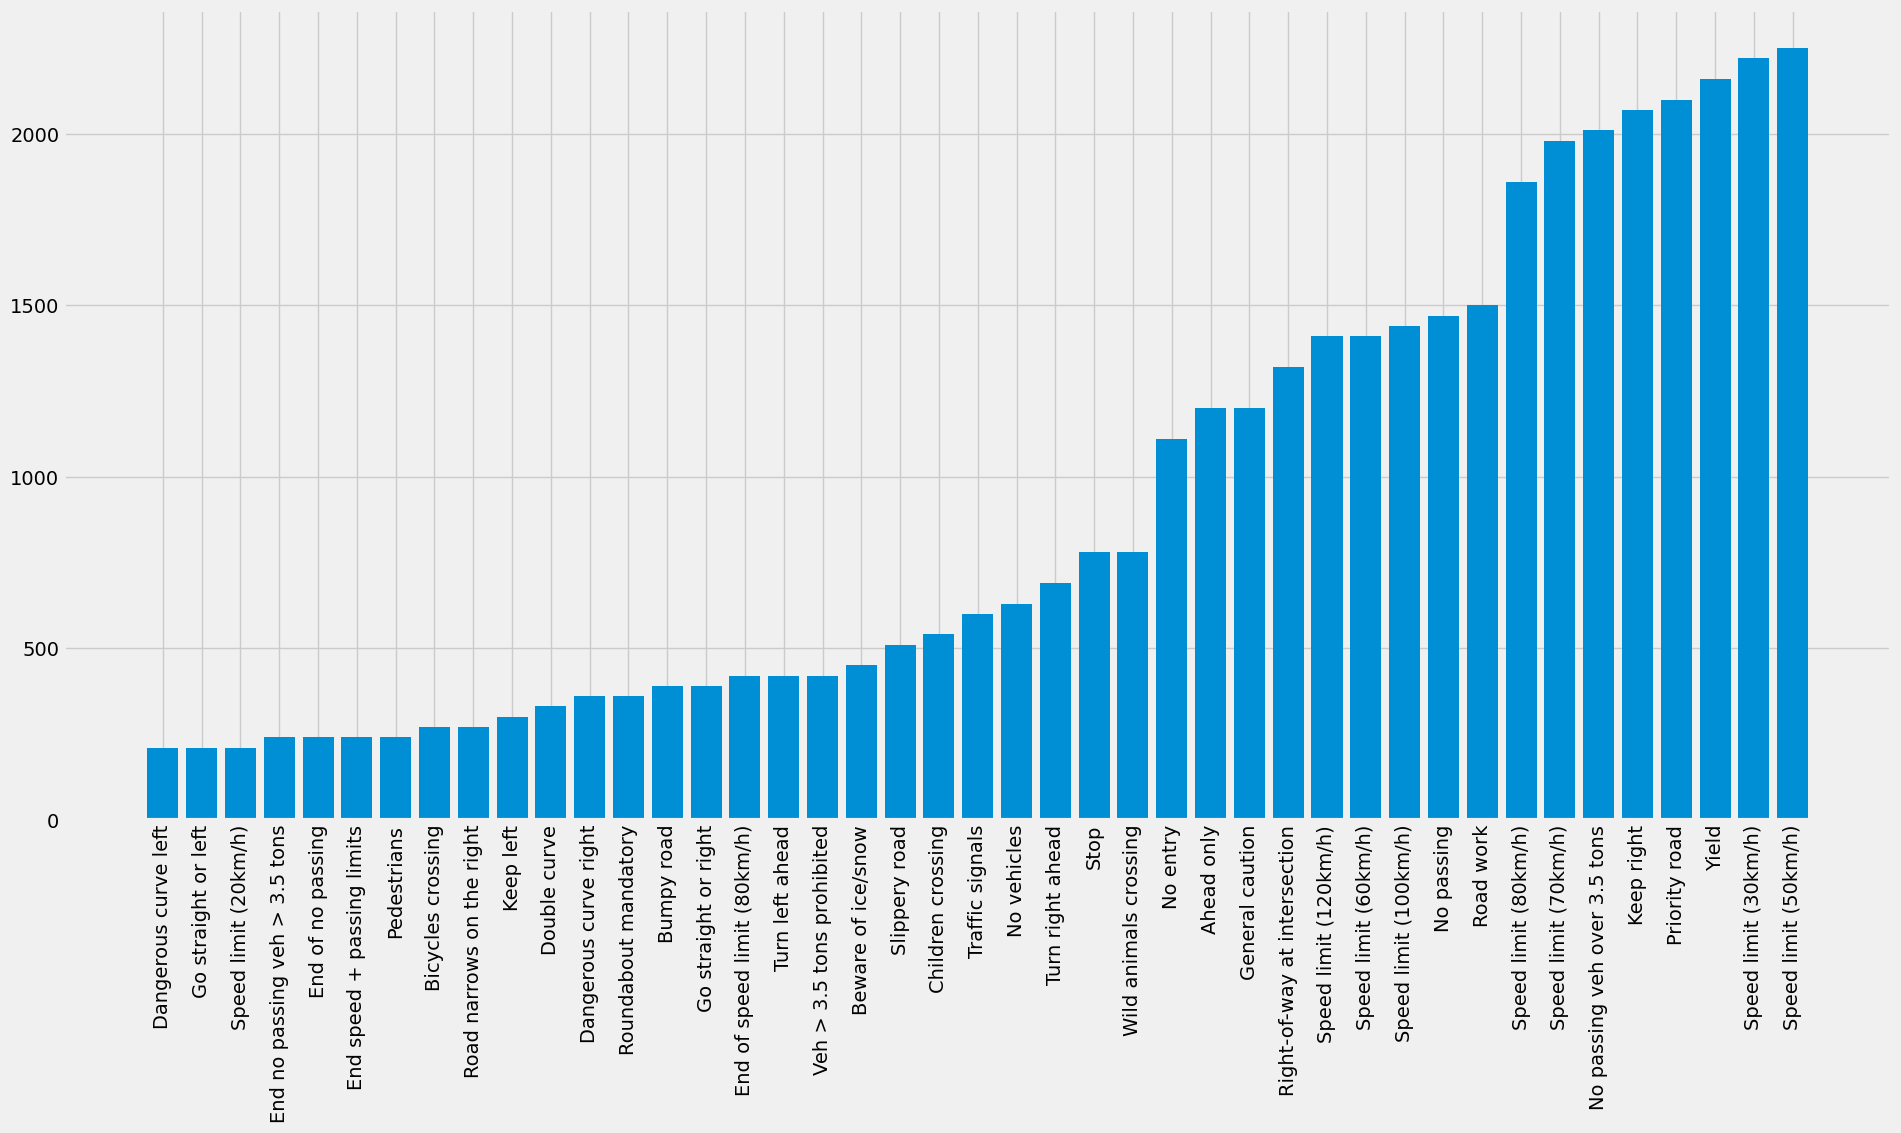

In [65]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

/var/folders/gs/flldrsnj66jd_2fq4nngd5b40000gn/T/ipykernel_94325/1256017970.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


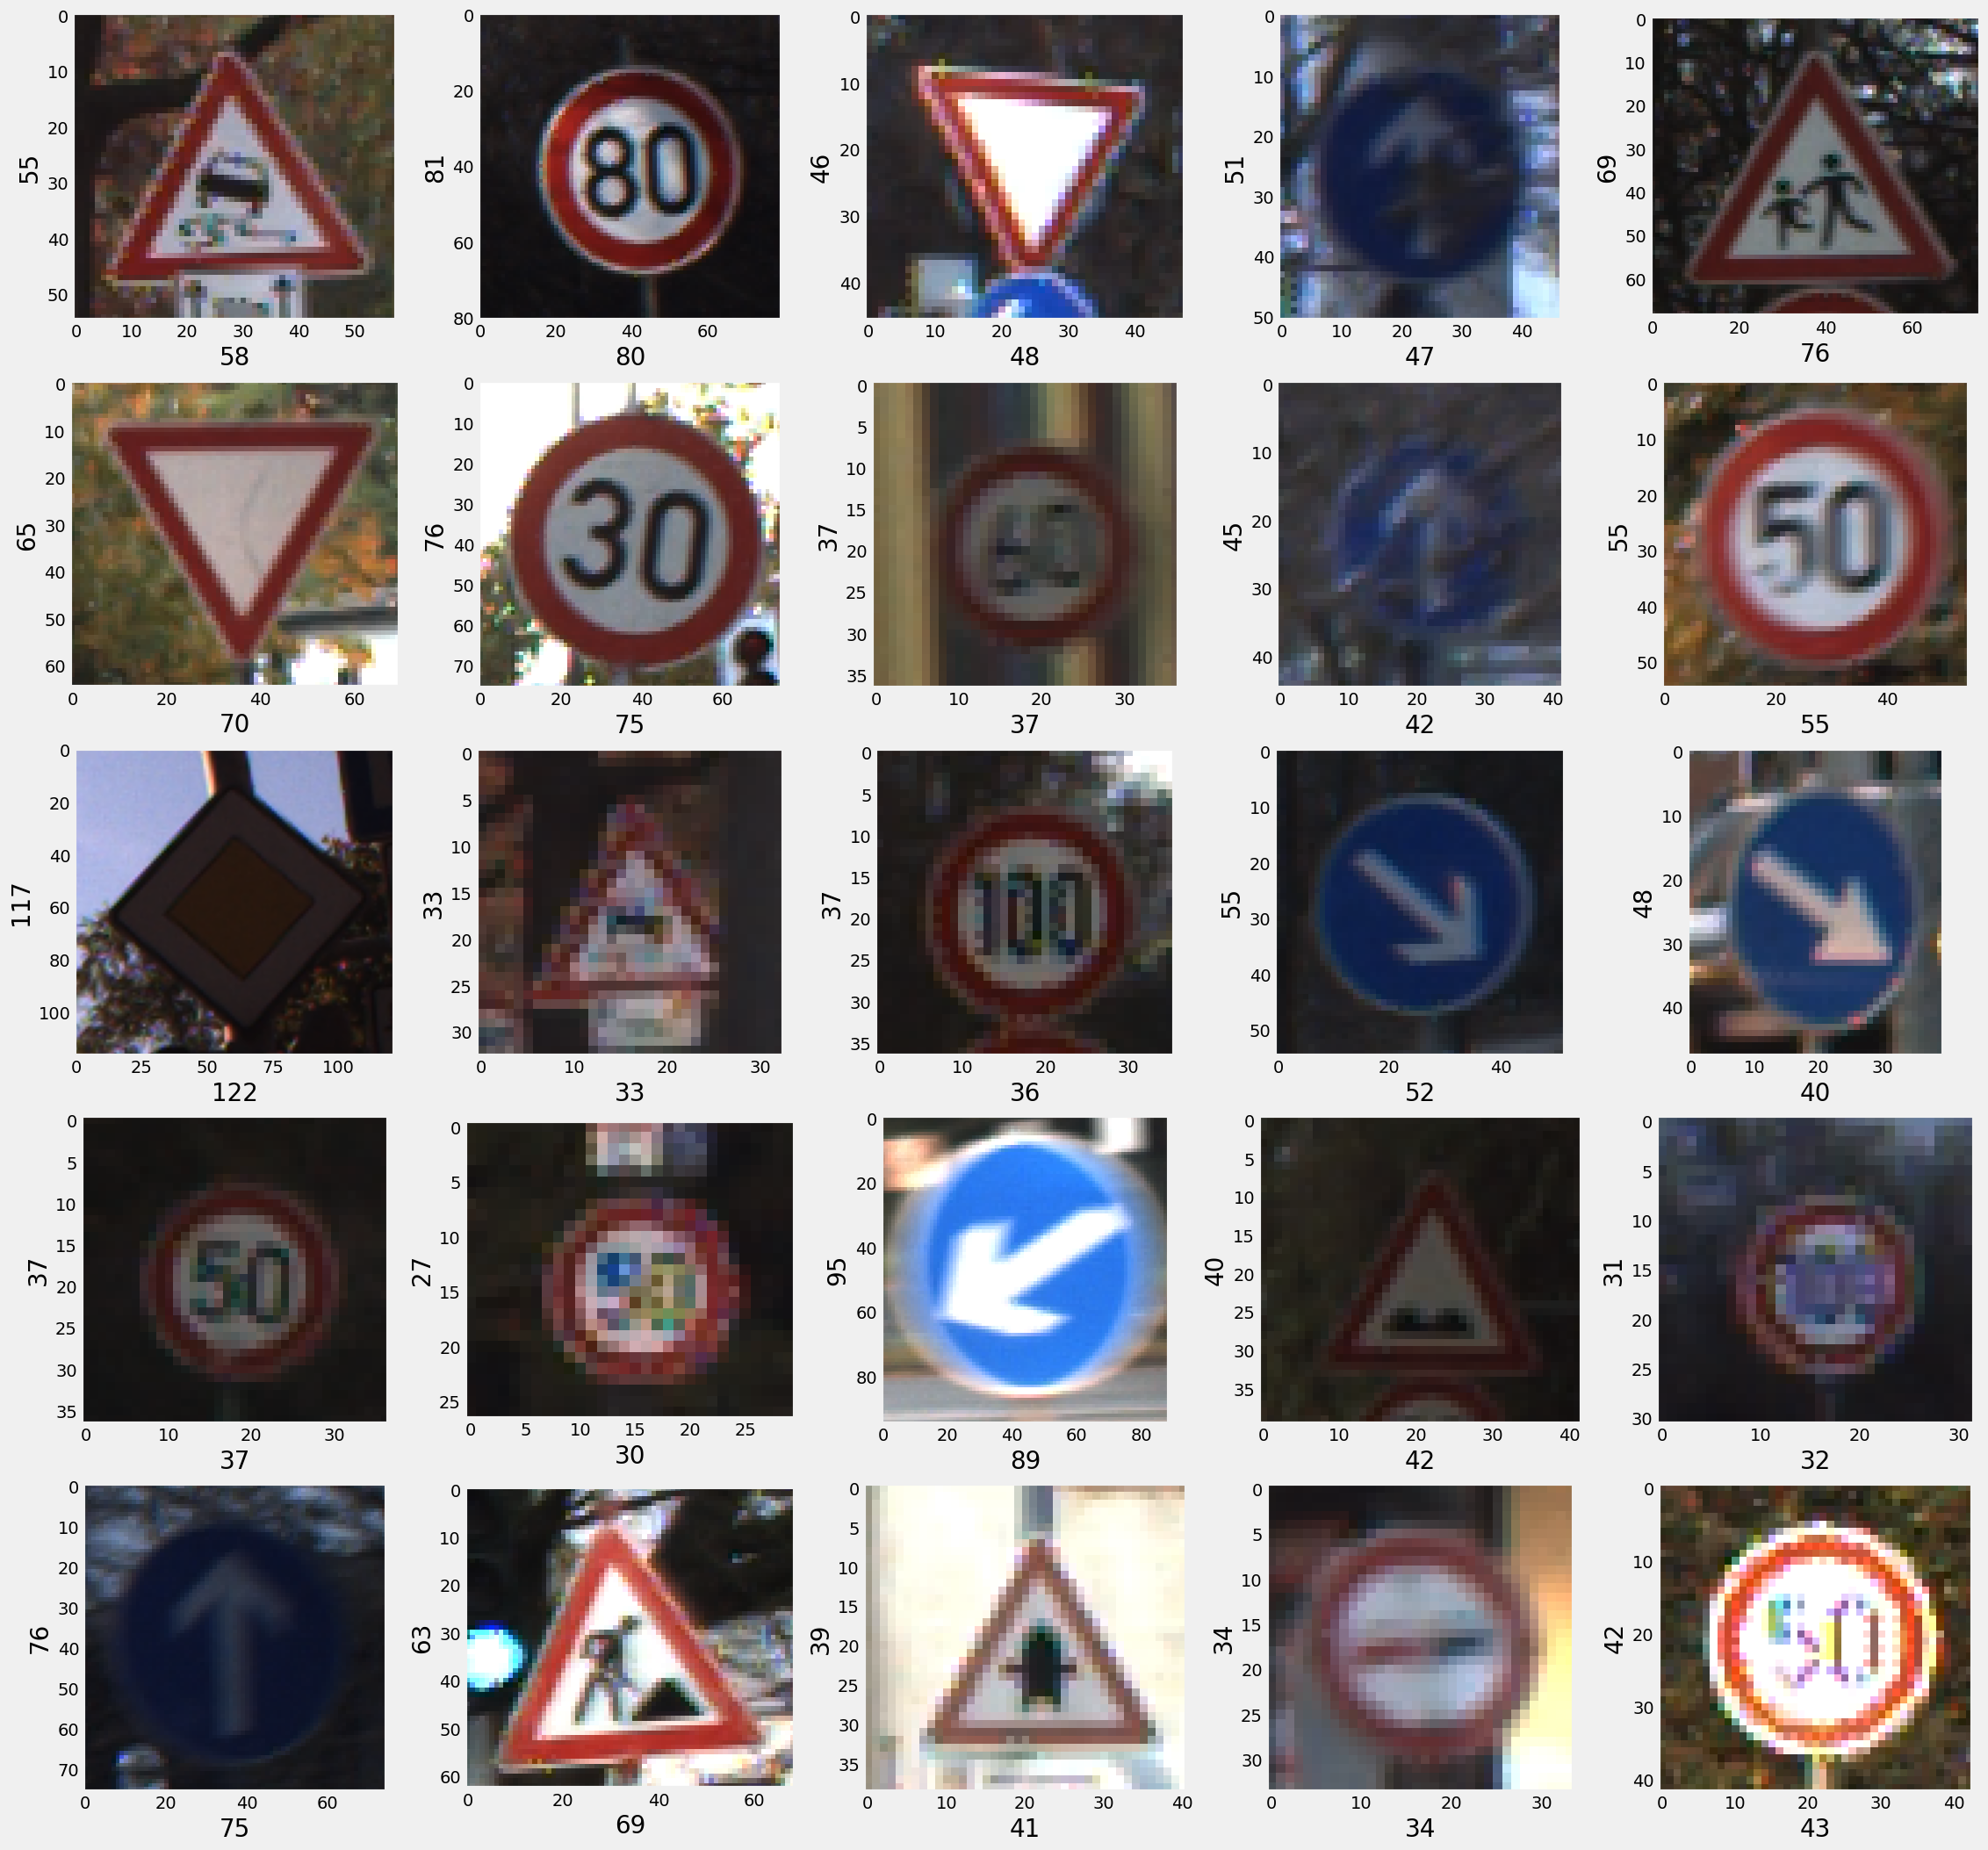

In [66]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Collecting the Training Data

In [67]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


Shuffling the training data (Xáo Trộn Data)

In [68]:
shuffle_indexes = np.arange(image_data.shape[0]) 
np.random.shuffle(shuffle_indexes) 
image_data = image_data[shuffle_indexes] 
image_labels = image_labels[shuffle_indexes] 

Tách dữ liệu (train/validation set)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


One hot encoding the labels (Xử lý dữ liệu labels)

In [70]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


BUILD MODEL

In [71]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [79]:
leaning_rate = 0.001
epochs = 30
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
epochs = 30 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
opt = Adam(learning_rate=leaning_rate, decay=leaning_rate / (epochs * 0.5))

TĂNG CƯỜNG DỮ LIỆU VÀ ĐÀO TẠO MÔ HÌNH

In [78]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


2022-12-20 16:32:33.099646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - ETA: 0s - loss: 0.9809 - accuracy: 0.7303

2022-12-20 16:32:58.529210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - 30s 34ms/step - loss: 0.9809 - accuracy: 0.7303 - val_loss: 0.1295 - val_accuracy: 0.9539
Epoch 2/30
858/858 [==============================] - 25s 29ms/step - loss: 0.1758 - accuracy: 0.9459 - val_loss: 0.0353 - val_accuracy: 0.9895
Epoch 3/30
858/858 [==============================] - 25s 29ms/step - loss: 0.1116 - accuracy: 0.9650 - val_loss: 0.0407 - val_accuracy: 0.9871
Epoch 4/30
858/858 [==============================] - 25s 29ms/step - loss: 0.0946 - accuracy: 0.9711 - val_loss: 0.0386 - val_accuracy: 0.9877
Epoch 5/30
858/858 [==============================] - 25s 29ms/step - loss: 0.0737 - accuracy: 0.9785 - val_loss: 0.0489 - val_accuracy: 0.9861
Epoch 6/30
858/858 [==============================] - 25s 29ms/step - loss: 0.0743 - accuracy: 0.9768 - val_loss: 0.0176 - val_accuracy: 0.9955
Epoch 7/30
858/858 [==============================] - 25s 29ms/step - loss: 0.0638 - accuracy: 0.9809 - val_loss: 0.0156 - val_accuracy: 0.9957
Epo

ĐÁNH GIÁ MÔ HÌNH

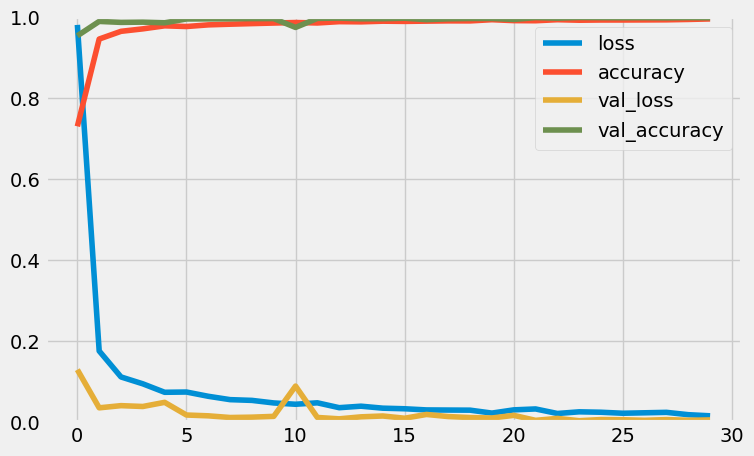

In [80]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

CHẠY DỰ ĐOÁN

In [81]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

#pred = model.predict_classes(X_test)

pred = np.argmax(model.predict(X_test),axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

 25/395 [>.............................] - ETA: 1s

2022-12-20 17:02:32.180927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


395/395 [==============================] - 2s 4ms/step
Test Data accuracy:  98.35312747426762


MA TRẬN NHẦM LẪN (Confusion matrix)

In [82]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<AxesSubplot: >

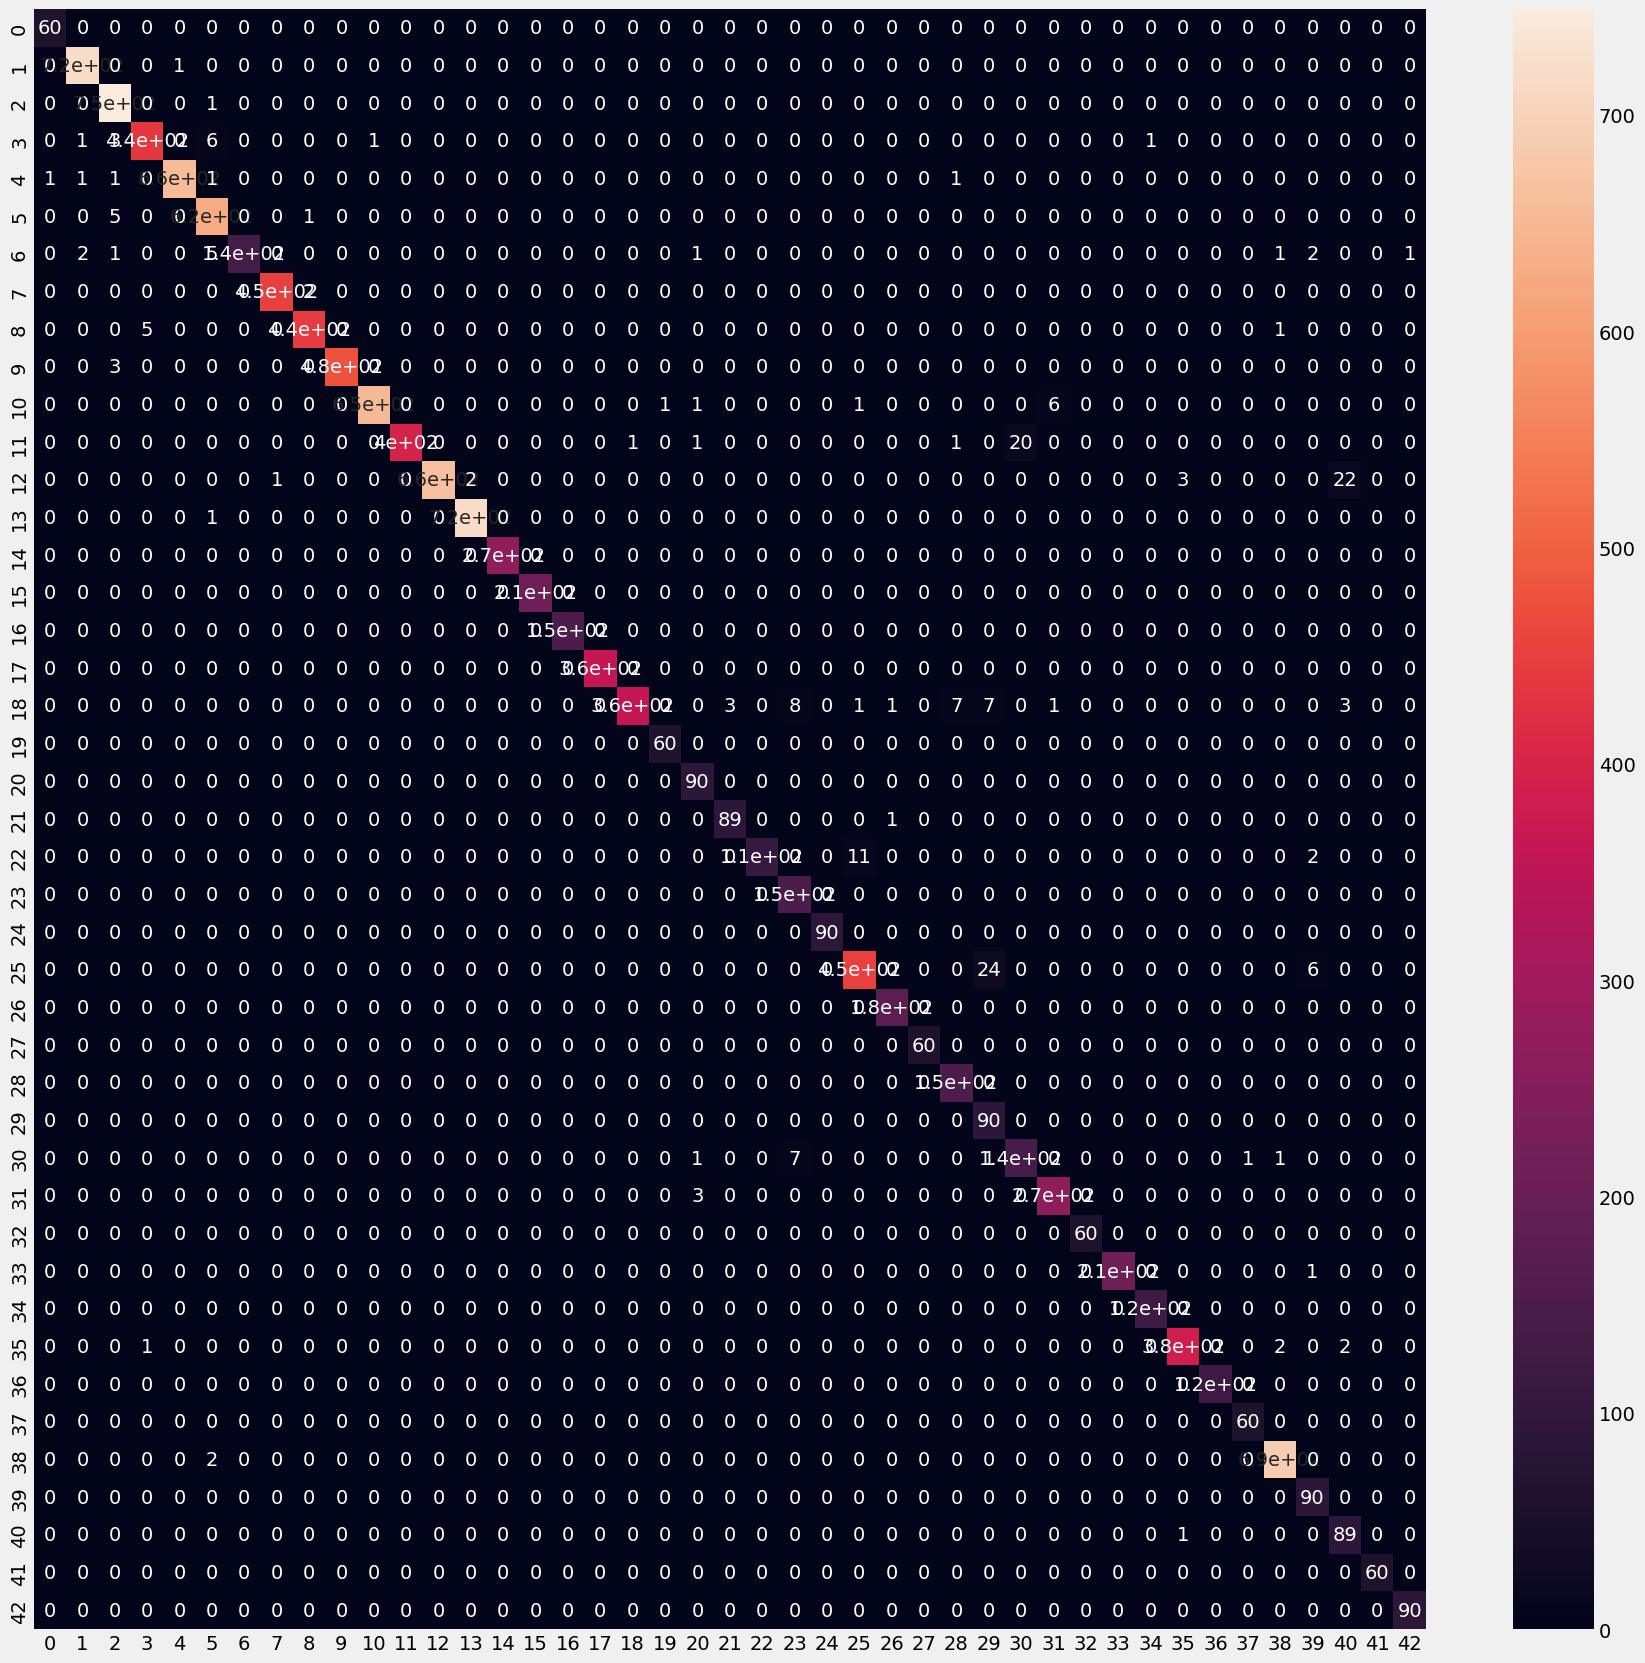

In [83]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

BÁO CÁO PHÂN LOẠI (Classification report)

In [84]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       0.99      0.97      0.98       450
           4       1.00      0.99      1.00       660
           5       0.97      0.99      0.98       630
           6       1.00      0.91      0.95       150
           7       1.00      1.00      1.00       450
           8       0.99      0.99      0.99       450
           9       1.00      0.99      1.00       480
          10       1.00      0.99      0.99       660
          11       1.00      0.95      0.97       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

DỰ ĐOÁN DỮ LIỆU THỬ NGHIỆM (Predictions on Test Data)

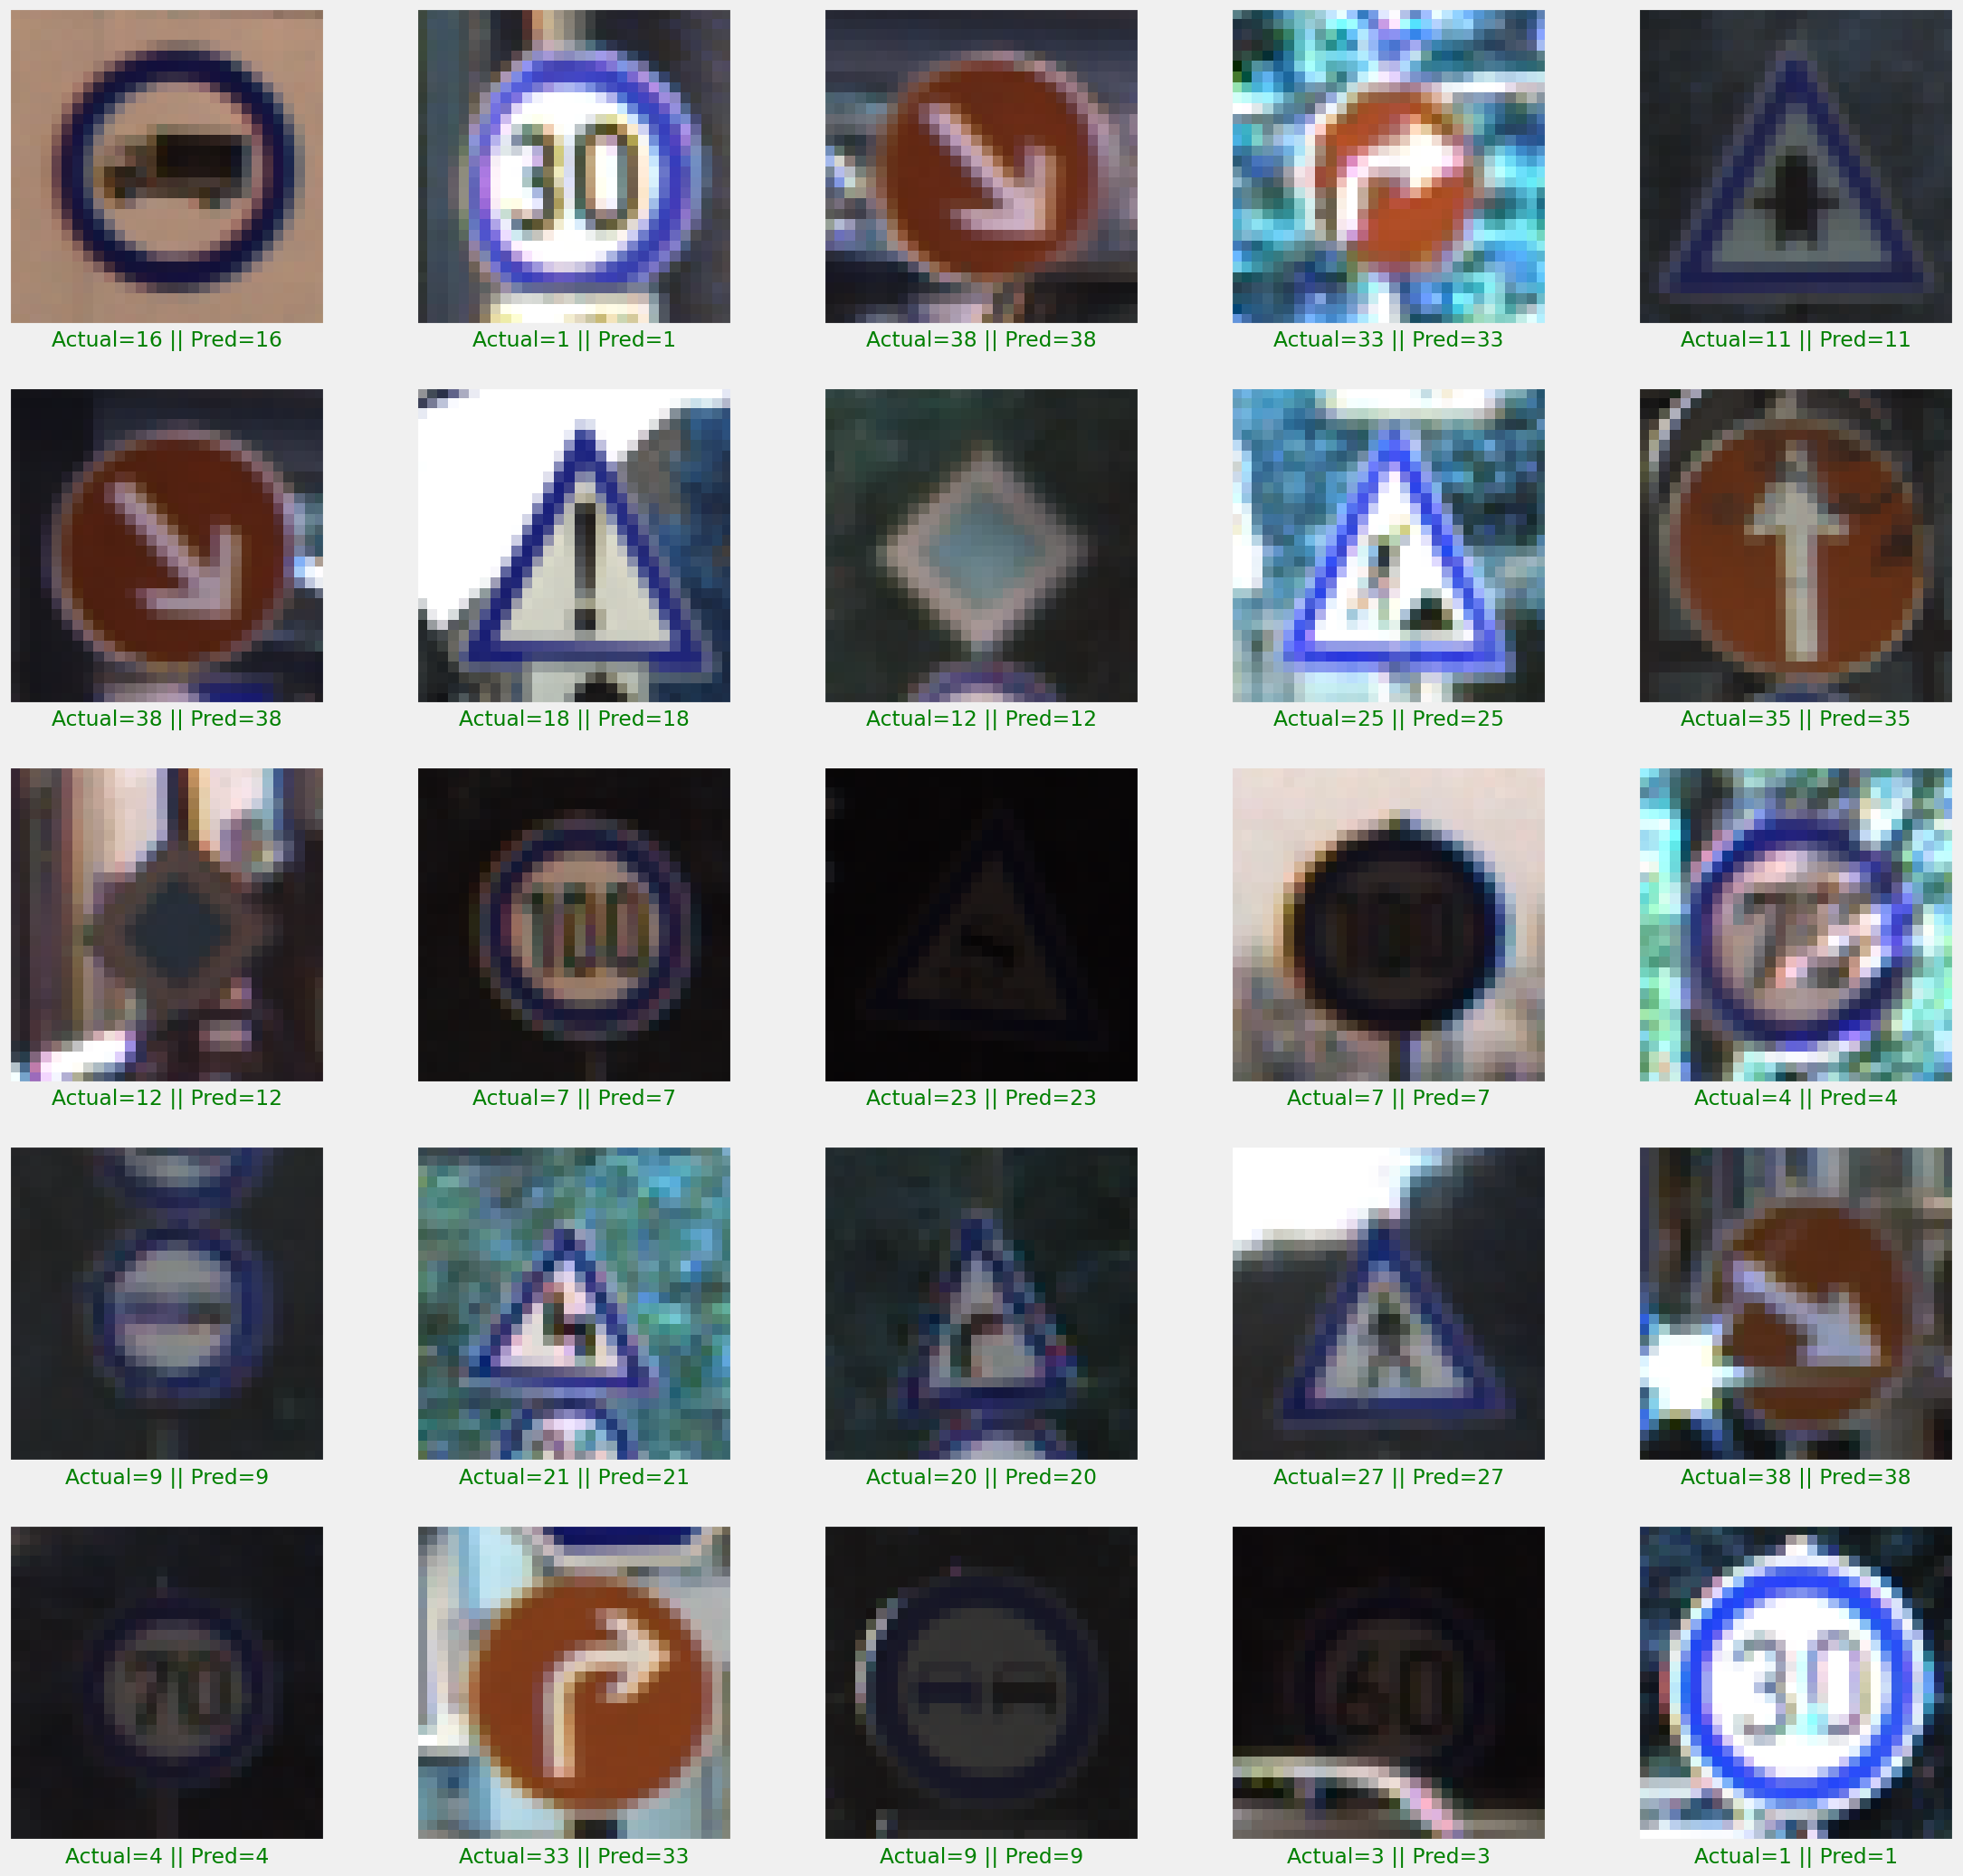

In [85]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()